# Example of analysis script to get upper limits using csdmatter app

In [1]:
#   Default imports
import gammalib
import ctools
import cscripts

from ctaAnalysis.csdmatter import csdmatter

import os

In [2]:
#   Name of fits with events from a dm simulation
#   The fits I am using here is obtained from 
#   the example "Simulation of gamma-ray emission from a Toy Dark halo"
file = 'ToyDarkHalo_dmflux_mass1000.0_chTau_DM001.fits'

In [3]:
#   csdmatter App input parameters
#   I know there are a lot of input parameters
#   And, at some point, some of the parameters can change, BTW
mmin          = 100.0         #   Minimum value of mass range to compute ULs (in GeV)
mmax          = 1.e+5         #   Maximum value of mass range to compute ULs (in GeV)
mnumpoints    = 10            #   Number of points to compute in the range [mmin,mmax]
process       = 'ANNA'        #   Process
channel       = 'b'           #   annihilation channel
ewcorrections = True          #   include EW corrections. I am using PPPC4DMID tables
logsigmav     = -25.443697    #   Log of sigmav (~3.6e-26)
logastfactor  = 18.7          #   Log of Jfactor
redshift      = 0.02          #   to take into account EBL
eblmodel      = 'dominguez'   #   EBL model to use with ebl-table
emin          = 30            #   Minimum energy to compute gamma-ray flux (in GeV)
emax          = 1.e+5         #   Maximum energy to compute gamma-ray flux (in GeV)
modtype       = 'PointSource' #   Model type
ra            = 188.0         #   in degrees
dec           = 12.5          #   in degrees
nthreads      = 1             #   At this moment just 1 thread.
                              #   I need to check how to implement multithread
caldb         = 'prod3b-v2'
irf           = 'North_z40_50h'
srcname       = 'ToyDarkHalo' #   name of the source

In [4]:
#   Name of file to save results for every simulation
ofname = 'dmResultsExample{0}.fits'.format( srcname )

In [5]:
#   Create instance of csdmatter app
thistool = csdmatter()

#   Passing input parameter to the app
thistool[ 'inobs' ]         = file
thistool[ 'srcname' ]       = srcname
thistool[ 'mmin' ]          = mmin
thistool[ 'mmax' ]          = mmax
thistool[ 'mnumpoints' ]    = mnumpoints
thistool[ 'process' ]       = process
thistool[ 'channel' ]       = channel
thistool[ 'ewcorrections' ] = ewcorrections
thistool[ 'logsigmav' ]     = logsigmav
thistool[ 'logastfactor' ]  = logastfactor
thistool[ 'redshift' ]      = redshift
thistool[ 'eblmodel' ]      = eblmodel
thistool[ 'emin' ]          = emin
thistool[ 'emax' ]          = emax
thistool[ 'modtype' ]       = modtype
thistool[ 'ra' ]            = ra
thistool[ 'dec' ]           = dec
thistool[ 'caldb' ]         = caldb
thistool[ 'irf' ]           = irf
thistool[ 'nthreads' ]      = nthreads
thistool[ 'outfile' ]       = ofname
#thistool[ 'clobber' ]       = True

In [6]:
#   Then, execute the csdmatter tool
thistool.execute()

In [7]:
#   Take a look to the results
fits  = gammalib.GFits( ofname )
table = fits.table( 1 )

#   Check the name of the different colums saved in the fits
for ncol in range( table.ncols() ) :
    print( table[ ncol ].name() )

RefEnergy
Mass
Flux
EFlux
TS
UpperLimit
ULCrossSection
RefCrossSection
ScaleFactor


In [8]:
#   Get masses and values of the upperlimits
masses   = [ row for row in table[ 'Mass' ] ]
sigmavul = [ row for row in table[ 'ULCrossSection' ] ]

print( 'Mass (TeV)\tUL[sigmav](cm**3/s)\t' )
for nrow in range( table.nrows() ) :
    print( '{:.2e}:\t\t{:.3e}'.format( table[ 'Mass' ][ nrow ] , table[ 'ULCrossSection' ][ nrow ]) )

Mass (TeV)	UL[sigmav](cm**3/s)	
1.00e-01:		8.081e-22
2.15e-01:		2.356e-22
4.64e-01:		9.730e-23
1.00e+00:		5.093e-23
2.15e+00:		3.019e-23
4.64e+00:		2.701e-23
1.00e+01:		4.107e-23
2.15e+01:		8.007e-23
4.64e+01:		1.667e-22
1.00e+02:		3.662e-22


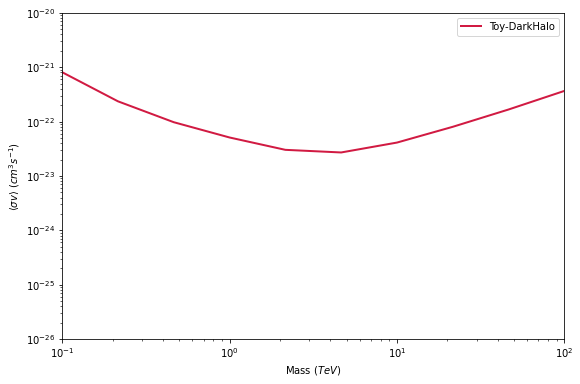

In [9]:
#   Plot the results
import matplotlib.pyplot as plt

fig , ax = plt.subplots( figsize=( 9 , 6 ) )

ax.plot( masses , sigmavul , color=( 0.82 , 0.10 , 0.26 ) , lw=2 , label='Toy-DarkHalo' )

ax.set_xlim( 1.e-1 , 1.e+2 )
ax.set_ylim( 1.e-26 , 1.e-20 )
ax.set_xscale( 'log' )
ax.set_yscale( 'log' )
ax.set_xlabel( 'Mass $(TeV)$' )
ax.set_ylabel( '$\\langle\\sigma v\\rangle$ ($cm^{3} s^{-1}$)' )

ax.legend( loc='best' , prop={ 'size': 10 } )

plt.show()